# Лабораторная работа 3.1 Анализ и визуализация временного ряда бизнес-показателей


**Цель работы.** Освоить ключевые методы анализа временных рядов на языке Python для решения практических бизнес-задач, таких как прогнозирование, выявление трендов и сезонности в экономических показателях.

## Введение. Почему временные ряды важны для бизнеса?

Временные ряды — это наборы данных, где каждая точка привязана к определенному моменту времени. Для бизнес-информатики это один из самых ценных активов, позволяющий:

- **Прогнозировать спрос.** Оптимизировать запасы и логистику.
- **Анализировать финансовые рынки.** Предсказывать цены акций и курсы валют.
- **Оценивать эффективность маркетинга.** Отслеживать влияние рекламных кампаний на продажи во времени.
- **Планировать ресурсы.** Прогнозировать нагрузку на серверы или количество обращений в колл-центр.

В этой работе мы научимся извлекать из временных данных ценные инсайты, строить и оценивать прогнозные модели.

### Основные характеристики временных рядов

- **Тренд (Trend).** Долгосрочное направление движения ряда (рост, падение, стагнация).
- **Сезонность (Seasonality).** Периодические, повторяющиеся колебания (например, рост продаж перед Новым годом).
- **Циклы (Cycles).** Долгосрочные волнообразные колебания, не связанные с фиксированным периодом, как у сезонности (например, экономические циклы).
- **Шум (Noise/Residual).** Случайные, непрогнозируемые колебания.
- **Стационарность.** Свойство ряда, при котором его статистические характеристики (среднее, дисперсия) не меняются со временем. Большинство моделей требуют, чтобы ряд был стационарным.

## Часть 1. Подготовка к анализу

Перед началом работы установим и импортируем все необходимые библиотеки.

In [34]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn -q

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Работа с датами и временем в Pandas

Правильная работа с временными метками — основа анализа временных рядов. Pandas предоставляет мощный инструментарий для этого.

**Задание 1. Создание DataFrame и преобразование в формат даты**

Создайте DataFrame на основе предоставленных данных о продажах. Преобразуйте столбец `'Дата'` в специальный формат `datetime` с помощью `pd.to_datetime()` и выведите типы данных DataFrame с помощью `.info()`.

In [35]:
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

# Ваш код здесь
# 1. Создайте DataFrame 'df' из словаря 'data'
df = pd.DataFrame(data)
# 2. Преобразуйте столбец 'Дата'
df['Дата'] = pd.to_datetime(df['Дата'])
# 3. Выведите информацию о DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Дата     5 non-null      datetime64[ns]
 1   Продажи  5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 212.0 bytes


**Задание 2. Установка временного индекса**

Для удобной работы с временными рядами столбец с датами часто устанавливают в качестве индекса DataFrame. Используйте метод `.set_index()` для установки столбца `'Дата'` в качестве индекса.

In [36]:
# Ваш код здесь
# Установите 'Дата' в качестве индекса для df
df.set_index('Дата', inplace=True)
print(df)

            Продажи
Дата               
2023-01-01     1000
2023-02-01     1200
2023-03-01     1300
2023-04-01     1100
2023-05-01     1400


**Задание 3. Фильтрация данных по дате**

Используя временной индекс, выберите данные о продажах за период с марта по апрель 2023 года включительно.

In [37]:
# Ваш код здесь
filtered_data = df['2023-03':'2023-04']
print(filtered_data)

            Продажи
Дата               
2023-03-01     1300
2023-04-01     1100


### Обработка пропущенных значений

Реальные бизнес-данные часто содержат пропуски. Их корректная обработка — критически важный шаг.

**Задание 4. Обнаружение пропущенных значений**

Создайте новый DataFrame `df_missing` с пропущенным значением. Используйте `.isnull().sum()` для подсчета количества пропусков в каждом столбце.

In [38]:
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                  'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Ваш код здесь
# Посчитайте пропущенные значения
missing_count = df_missing.isnull().sum()
print(missing_count)

Продажи    1
dtype: int64


**Задание 5. Заполнение пропусков средним значением**

Заполните пропущенное значение в столбце `'Продажи'` средним значением этого же столбца. Это более robustный подход, чем заполнение нулем. Не забудьте переприсвоить результат.

In [39]:
# Ваш код здесь
# 1. Рассчитайте среднее по столбцу 'Продажи'
mean_value = df_missing['Продажи'].mean()
print(f"Среднее значение: {mean_value}")
# 2. Заполните пропуски с помощью .fillna()
df_missing['Продажи'] = df_missing['Продажи'].fillna(mean_value)
print(df_missing)


Среднее значение: 1200.0
            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1200.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


**Задание 6. Заполнение пропусков методом интерполяции**

Интерполяция заполняет пропуски, вычисляя промежуточные значения между двумя известными точками. Это часто дает более реалистичный результат. Примените метод `.interpolate()` к `df_missing`.

In [40]:
# Ваш код здесь
df_missing_interpolated = df_missing.copy()
df_missing_interpolated['Продажи'] = df_missing_interpolated['Продажи'].interpolate()
print(df_missing_interpolated)


            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1200.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


## Часть 2. Исследовательский анализ временных рядов (EDA)

На этом этапе мы будем использовать реальный набор данных о ежемесячном производстве бензина в США. Наша цель — визуализировать данные и выявить их основные компоненты.

**Задание 7. Загрузка и подготовка данных**

Загрузите данные по ссылке. Убедитесь, что столбец с датой преобразован в `datetime` и установлен в качестве индекса. Выведите первые 5 строк.

In [41]:
# Ваш код здесь
gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"

# Загрузите данные, используя parse_dates=['date'] и index_col='date'
gas_df = pd.read_csv(gas_url, parse_dates=['date'], index_col='date')
print("Первые 5 строк:")
print(gas_df.head())


Первые 5 строк:
            value
date             
1991-02-03  6.621
1991-02-10  6.433
1991-02-17  6.582
1991-02-24  7.224
1991-03-03  6.875


**Задание 8. Визуализация временного ряда**

Постройте линейный график для столбца `'value'`, чтобы визуально оценить данные. Добавьте заголовок и подписи осей.

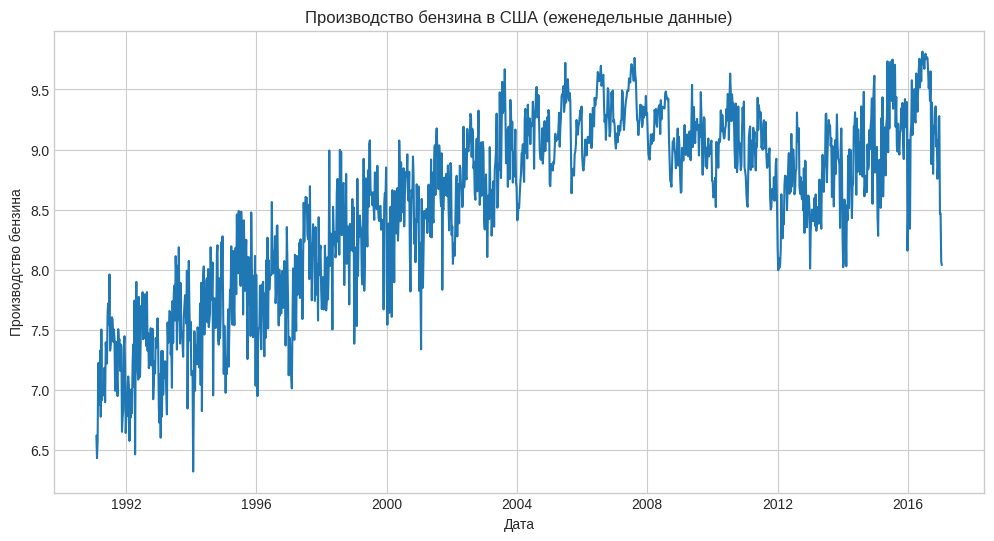

In [42]:
# Ваш код здесь
plt.figure(figsize=(12, 6))
plt.plot(gas_df.index, gas_df['value'])
plt.title('Производство бензина в США (еженедельные данные)')
plt.xlabel('Дата')
plt.ylabel('Производство бензина')
plt.grid(True)
plt.show()

**Задание 9. Ресэмплинг для агрегации данных**

Исходные данные имеют еженедельную частоту, что делает график 'шумным'. Преобразуйте ряд в ежемесячный (`'M'`), агрегируя значения с помощью среднего (`.mean()`). Сохраните результат в `gas_monthly` и постройте график.

/tmp/ipython-input-558045225.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_monthly = gas_df.resample('M').mean()


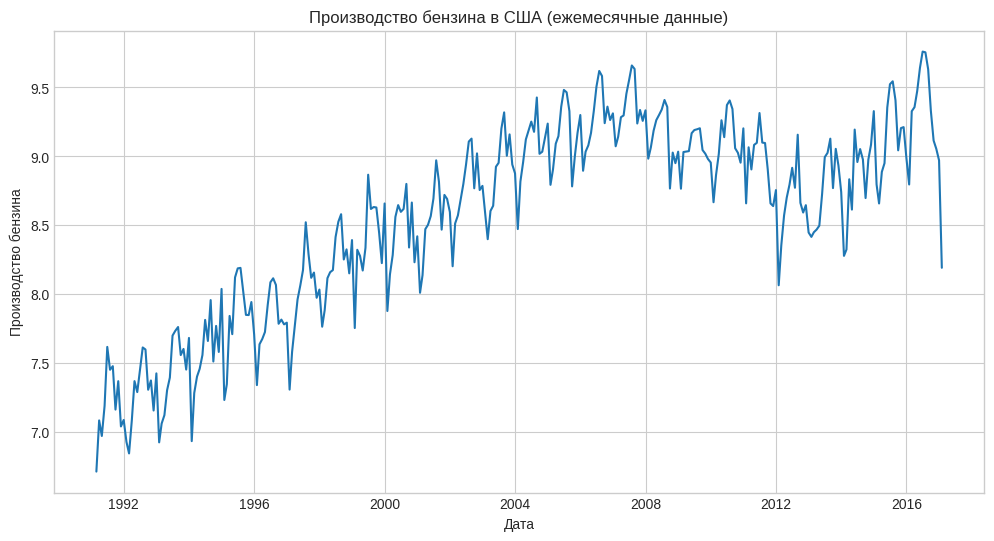

In [43]:
# Ваш код здесь
# 1. Выполните ресэмплинг
gas_monthly = gas_df.resample('M').mean()
# 2. Постройте график для gas_monthly['value']
plt.figure(figsize=(12, 6))
plt.plot(gas_monthly.index, gas_monthly['value'])
plt.title('Производство бензина в США (ежемесячные данные)')
plt.xlabel('Дата')
plt.ylabel('Производство бензина')
plt.grid(True)
plt.show()


**Задание 10. Сглаживание с помощью скользящего среднего**

Чтобы лучше увидеть долгосрочный тренд, примените скользящее среднее. Создайте новый столбец `'rolling_mean_12'` в `gas_monthly`, рассчитав среднее за 12 месяцев с помощью `.rolling(window=12).mean()`. Постройте на одном графике исходный ряд и сглаженный.

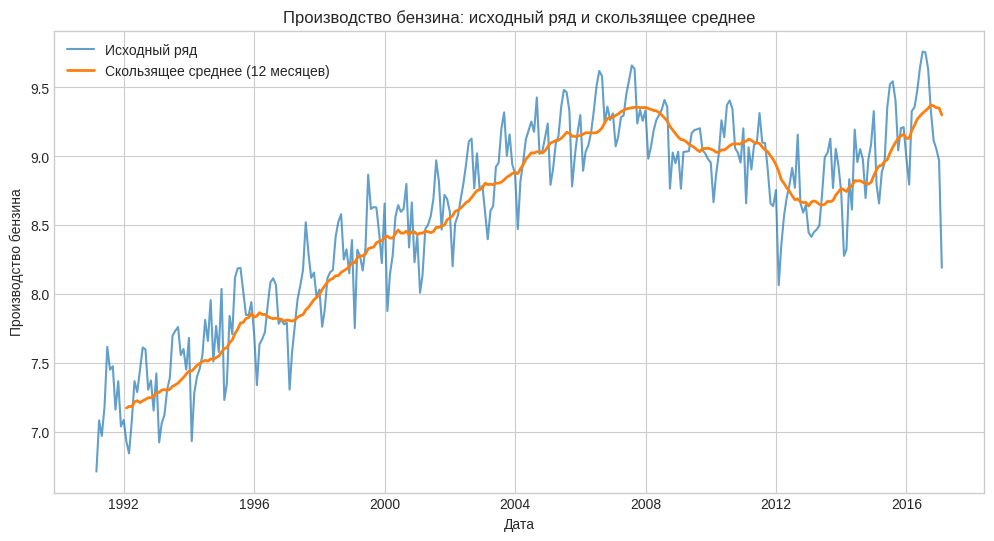

In [44]:
# Ваш код здесь
# 1. Рассчитайте скользящее среднее
gas_monthly['rolling_mean_12'] = gas_monthly['value'].rolling(window=12).mean()

# 2. Постройте оба графика
plt.figure(figsize=(12, 6))
plt.plot(gas_monthly.index, gas_monthly['value'], label='Исходный ряд', alpha=0.7)
plt.plot(gas_monthly.index, gas_monthly['rolling_mean_12'], label='Скользящее среднее (12 месяцев)', linewidth=2)
plt.title('Производство бензина: исходный ряд и скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Производство бензина')
plt.legend()
plt.grid(True)
plt.show()


**Задание 11. Декомпозиция временного ряда**

Используйте `seasonal_decompose` из `statsmodels`, чтобы разложить ежемесячный ряд `gas_monthly['value']` на тренд, сезонность и остаток. Визуализируйте результат с помощью метода `.plot()`.

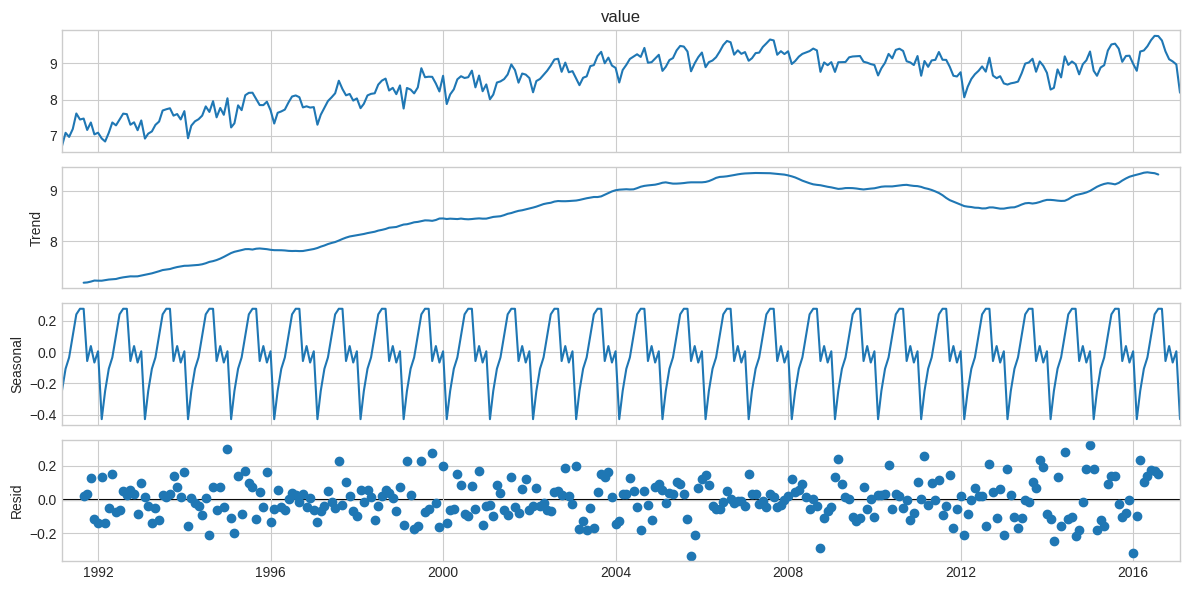

In [45]:
# Ваш код здесь
# 1. Выполните декомпозицию
decomposition = seasonal_decompose(gas_monthly['value'], model='additive', period=12)

# 2. Постройте график
decomposition.plot()
plt.tight_layout()
plt.show()


## Часть 3. Стационарность и корреляционный анализ

**Задание 12. Проверка на стационарность**

Проведите расширенный тест Дики-Фуллера (`adfuller`) для ряда `gas_monthly['value']`. Проанализируйте p-значение и сделайте вывод о стационарности ряда.

In [46]:
# Ваш код здесь
adf_result = adfuller(gas_monthly['value'])

print('Результаты теста Дики-Фуллера:')
print(f'ADF статистика: {adf_result[0]:.6f}')
print(f'p-value: {adf_result[1]:.6f}')
print('Критические значения:')
for key, value in adf_result[4].items():
    print(f'  {key}: {value:.6f}')

if adf_result[1] <= 0.05:
    print('\nВывод: Ряд стационарен (p-value <= 0.05)')
else:
    print('\nВывод: Ряд не стационарен (p-value > 0.05)')



Результаты теста Дики-Фуллера:
ADF статистика: -2.197750
p-value: 0.207063
Критические значения:
  1%: -3.452713
  5%: -2.871388
  10%: -2.572017

Вывод: Ряд не стационарен (p-value > 0.05)


**Задание 13. Достижение стационарности через дифференцирование**

Чтобы сделать ряд стационарным, примените к нему дифференцирование первого порядка с помощью метода `.diff()`. Удалите появившееся значение `NaN` и сохраните результат в `gas_monthly_diff`.

In [47]:
# Ваш код здесь
gas_monthly_diff = gas_monthly['value'].diff().dropna()
print(f"Размер дифференцированного ряда: {len(gas_monthly_diff)}")
print(f"Первые 5 значений:\n{gas_monthly_diff.head()}")


Размер дифференцированного ряда: 311
Первые 5 значений:
date
1991-03-31    0.37100
1991-04-30   -0.11275
1991-05-31    0.21850
1991-06-30    0.42725
1991-07-31   -0.16575
Freq: ME, Name: value, dtype: float64


**Задание 14. Повторная проверка на стационарность**

Проведите тест Дики-Фуллера для нового, дифференцированного ряда `gas_monthly_diff`. Сравните p-значение с предыдущим результатом.

In [48]:
# Ваш код здесь
adf_result_diff = adfuller(gas_monthly_diff)

print('Результаты теста Дики-Фуллера для дифференцированного ряда:')
print(f'ADF статистика: {adf_result_diff[0]:.6f}')
print(f'p-value: {adf_result_diff[1]:.6f}')
print('Критические значения:')
for key, value in adf_result_diff[4].items():
    print(f'  {key}: {value:.6f}')

if adf_result_diff[1] <= 0.05:
    print('\nВывод: Дифференцированный ряд стационарен (p-value <= 0.05)')
else:
    print('\nВывод: Дифференцированный ряд не стационарен (p-value > 0.05)')



Результаты теста Дики-Фуллера для дифференцированного ряда:
ADF статистика: -3.063923
p-value: 0.029341
Критические значения:
  1%: -3.452790
  5%: -2.871422
  10%: -2.572035

Вывод: Дифференцированный ряд стационарен (p-value <= 0.05)


**Задание 15. Анализ автокорреляции (ACF)**

Постройте график автокорреляционной функции (ACF) для стационарного ряда `gas_monthly_diff`. Это поможет определить порядок компоненты MA в модели ARIMA.

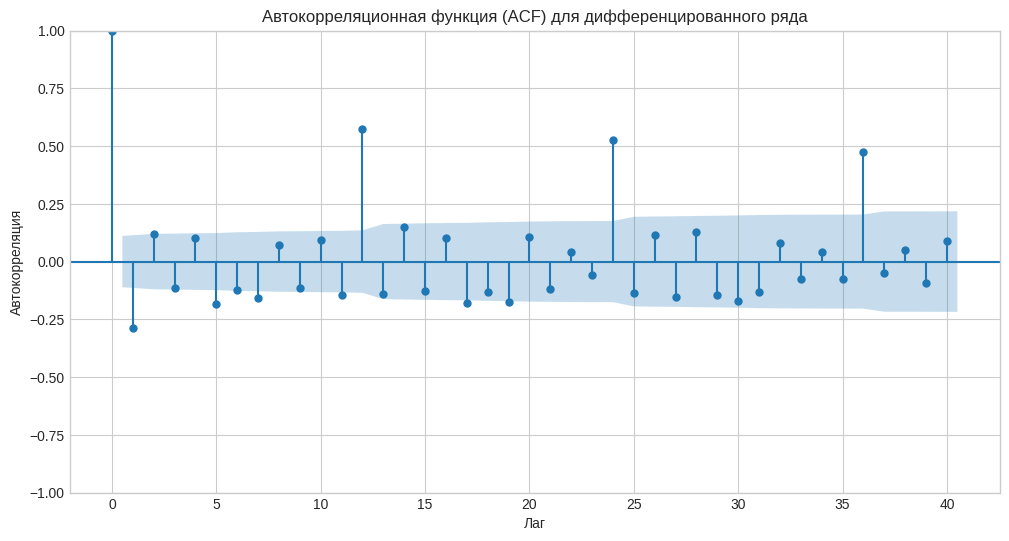

In [49]:
# Ваш код здесь

# Используйте plot_acf, передав в него ряд и ax
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(gas_monthly_diff, ax=ax, lags=40)
plt.title('Автокорреляционная функция (ACF) для дифференцированного ряда')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.grid(True)
plt.show()


**Задание 16. Анализ частичной автокорреляции (PACF)**

Постройте график частичной автокорреляционной функции (PACF) для `gas_monthly_diff`. Это поможет определить порядок компоненты AR в модели ARIMA.

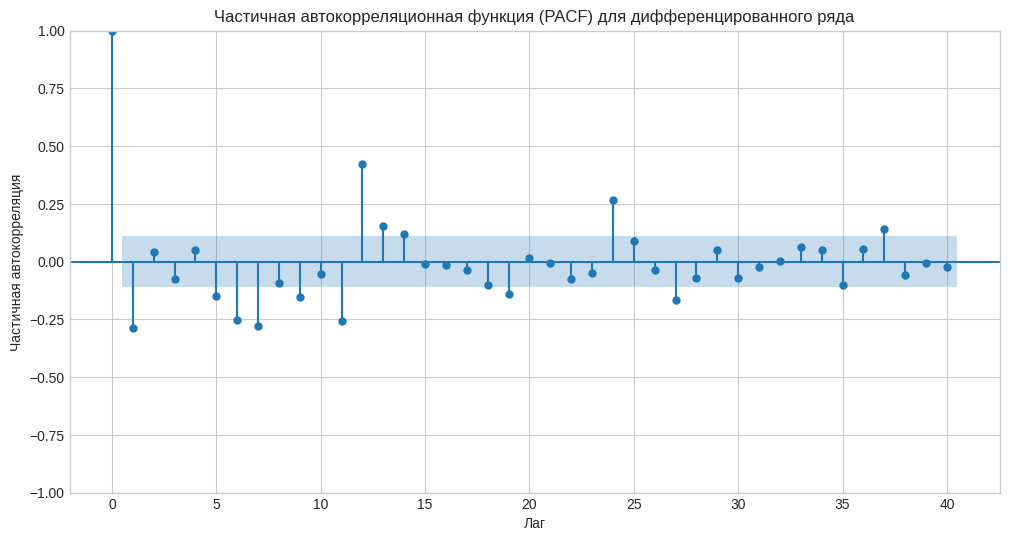

In [50]:
# Ваш код здесь

# Используйте plot_pacf, передав в него ряд и ax
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(gas_monthly_diff, ax=ax, lags=40)
plt.title('Частичная автокорреляционная функция (PACF) для дифференцированного ряда')
plt.xlabel('Лаг')
plt.ylabel('Частичная автокорреляция')
plt.grid(True)
plt.show()



## Часть 4. Построение и оценка прогнозной модели ARIMA

Модель ARIMA (AutoRegressive Integrated Moving Average) — одна из самых популярных моделей для прогнозирования временных рядов.

- **AR (p):** Авторегрессионная часть, использующая зависимость от `p` предыдущих значений.
- **I (d):** Интегрированная часть, отвечающая за количество дифференцирований (`d`) для достижения стационарности.
- **MA (q):** Часть скользящего среднего, использующая зависимость от `q` предыдущих ошибок прогноза.

**Задание 17. Разделение данных на обучающую и тестовую выборки**

Разделите `gas_monthly['value']` на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года) выборки. Это позволит нам оценить качество модели на данных, которые она не видела при обучении.

In [51]:
# Ваш код здесь
train_data = gas_monthly['value'][gas_monthly.index < '2015-01-01']
test_data = gas_monthly['value'][gas_monthly.index >= '2015-01-01']

print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print(f"Период обучающей выборки: {train_data.index.min()} - {train_data.index.max()}")
print(f"Период тестовой выборки: {test_data.index.min()} - {test_data.index.max()}")


Размер обучающей выборки: 287
Размер тестовой выборки: 25
Период обучающей выборки: 1991-02-28 00:00:00 - 2014-12-31 00:00:00
Период тестовой выборки: 2015-01-31 00:00:00 - 2017-01-31 00:00:00


**Задание 18. Обучение модели ARIMA**

Обучите модель ARIMA на обучающей выборке (`train_data`). На основе графиков ACF/PACF и того, что мы применили одно дифференцирование, выберем порядок `(p, d, q) = (2, 1, 2)`. Выведите сводку по модели с помощью `.summary()`.

In [52]:
# Ваш код здесь
# 1. Создайте модель ARIMA
model = ARIMA(train_data, order=(2, 1, 2))

# 2. Обучите модель
model_fit = model.fit()

# 3. Выведите сводку
print(model_fit.summary())



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  38.541
Date:                Mon, 08 Dec 2025   AIC                            -67.083
Time:                        20:07:07   BIC                            -48.803
Sample:                    02-28-1991   HQIC                           -59.756
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4038      0.086     -4.695      0.000      -0.572      -0.235
ar.L2          0.5961      0.086      6.952      0.000       0.428       0.764
ma.L1          0.1028      0.062      1.658      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Задание 19. Построение прогноза**

Сделайте прогноз на период, соответствующий тестовой выборке. Используйте `model_fit.predict()`, указав `start` и `end` индексы тестовой выборки.

In [53]:
# Ваш код здесь
forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
print(f"Прогноз на тестовый период:")
print(forecast.head(10))



Прогноз на тестовый период:
2015-01-31    9.115067
2015-02-28    9.127644
2015-03-31    8.995342
2015-04-30    9.056262
2015-05-31    8.952799
2015-06-30    9.030891
2015-07-31    8.937685
2015-08-31    9.021871
2015-09-30    8.932318
2015-10-31    9.018661
Freq: ME, Name: predicted_mean, dtype: float64


**Задание 20. Визуализация прогноза**

Постройте график, на котором будут отображены обучающие данные, реальные тестовые данные и ваш прогноз.

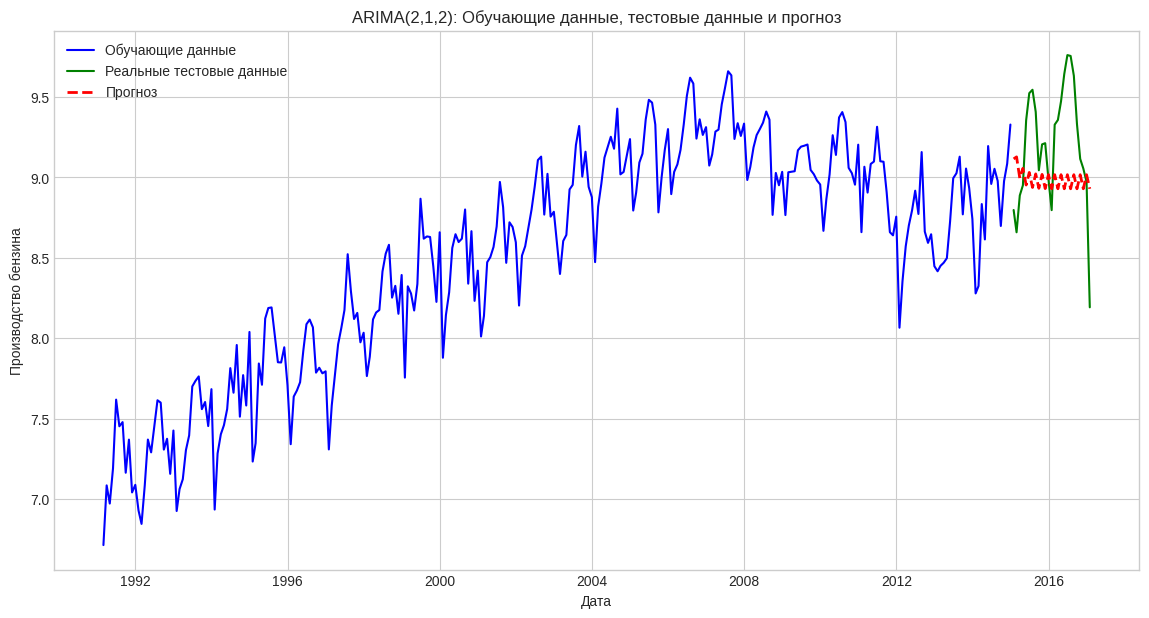

In [54]:
# Ваш код здесь
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data.values, label='Обучающие данные', color='blue')
plt.plot(test_data.index, test_data.values, label='Реальные тестовые данные', color='green')
plt.plot(forecast.index, forecast.values, label='Прогноз', color='red', linestyle='--', linewidth=2)
plt.title('ARIMA(2,1,2): Обучающие данные, тестовые данные и прогноз')
plt.xlabel('Дата')
plt.ylabel('Производство бензина')
plt.legend()
plt.grid(True)
plt.show()

# Добавьте линию для прогноза


**Задание 21. Оценка качества модели**

Рассчитайте метрику RMSE (Root Mean Squared Error) для оценки точности вашего прогноза. RMSE = `sqrt(mean_squared_error(y_true, y_pred))`.

In [55]:
# Ваш код здесь
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")



RMSE (Root Mean Squared Error): 0.4359


**Задание 22. Прогноз на будущее**

Теперь, когда модель оценена, используйте ее для прогнозирования на 12 месяцев вперед (за пределы имеющихся данных). Используйте метод `.forecast()`.

In [56]:
# Ваш код здесь
forecast_future = model_fit.forecast(steps=12)
print(f"Прогноз на 12 месяцев вперед:")
print(forecast_future)



Прогноз на 12 месяцев вперед:
2015-01-31    9.115067
2015-02-28    9.127644
2015-03-31    8.995342
2015-04-30    9.056262
2015-05-31    8.952799
2015-06-30    9.030891
2015-07-31    8.937685
2015-08-31    9.021871
2015-09-30    8.932318
2015-10-31    9.018661
2015-11-30    8.930415
2015-12-31    9.017516
Freq: ME, Name: predicted_mean, dtype: float64


**Задание 23. Визуализация прогноза на будущее**

Постройте график, включающий все исторические данные (`gas_monthly['value']`) и прогноз на будущее.

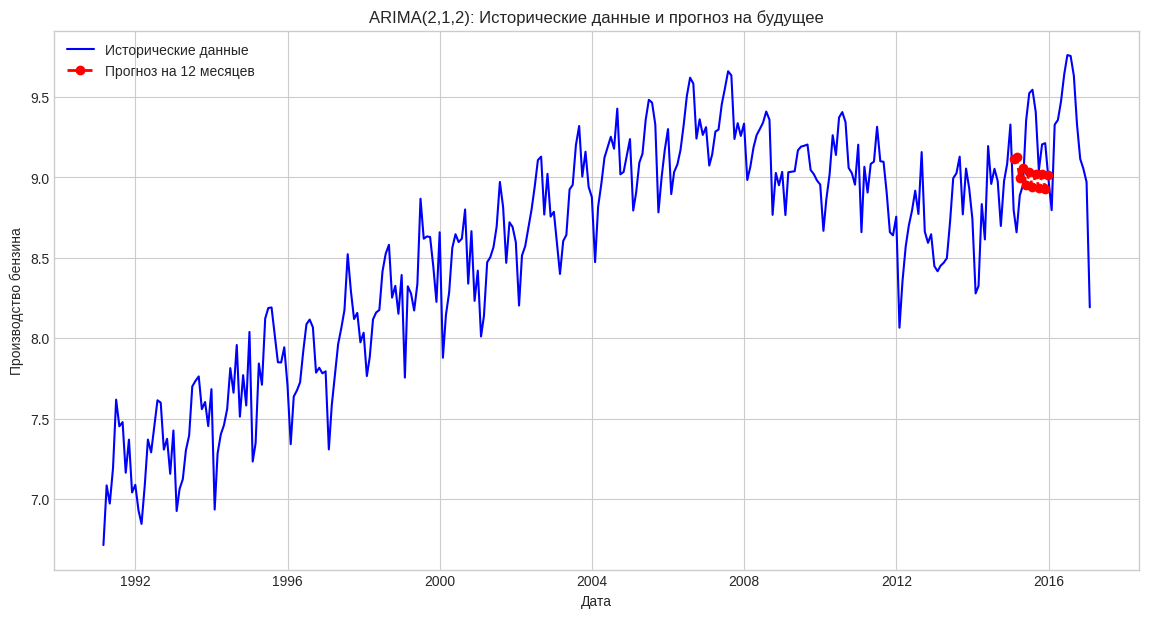

In [57]:
# Ваш код здесь

# Добавьте линию для прогноза на будущее
plt.figure(figsize=(14, 7))
plt.plot(gas_monthly.index, gas_monthly['value'], label='Исторические данные', color='blue')
plt.plot(forecast_future.index, forecast_future.values, label='Прогноз на 12 месяцев',
         color='red', linestyle='--', linewidth=2, marker='o')
plt.title('ARIMA(2,1,2): Исторические данные и прогноз на будущее')
plt.xlabel('Дата')
plt.ylabel('Производство бензина')
plt.legend()
plt.grid(True)
plt.show()


## Часть 5. Индивидуальные задания для самостоятельной работы

**Инструкция.** Выполните задания, соответствующие вашему варианту. В качестве основного набора данных используйте `gas_monthly` (ежемесячные данные о производстве бензина) или `unemployment_df` (квартальные данные об уровне безработицы), как указано в задании. Сначала загрузим второй датасет.

In [58]:
unemployment_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_unemployment.csv"
unemployment_df = pd.read_csv(unemployment_url, parse_dates=['date'], index_col='date')
print("Данные по безработице (head):")
print(unemployment_df.head())

print("\nДанные по производству бензина (head):")
print(gas_monthly.head())

Данные по безработице (head):
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2

Данные по производству бензина (head):
              value  rolling_mean_12
date                                
1991-02-28  6.71500              NaN
1991-03-31  7.08600              NaN
1991-04-30  6.97325              NaN
1991-05-31  7.19175              NaN
1991-06-30  7.61900              NaN


---
**Вариант 1:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2005 по 2010 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 6 месяцев.
4. **Стационарность:** Примените дифференцирование первого порядка и проведите тест Дики-Фуллера.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2014 года и сделайте прогноз на 12 шагов вперед.

---
**Вариант 2:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график всего временного ряда уровня безработицы.
3. **Декомпозиция:** Разложите ряд на тренд, сезонность и остаток.
4. **Корреляция:** Постройте график ACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,0) на данных до 2010 года и сделайте прогноз на 8 кварталов вперед.

---
**Вариант 3:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 1995 по 2000 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 24 месяца.
4. **Стационарность:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,1) на данных до 2013 года и сделайте прогноз на 12 шагов.

---
**Вариант 4:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2000 года до конца.
3. **Стационарность:** Примените дифференцирование и проверьте на стационарность с помощью теста ADF.
4. **Корреляция:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2012 года, сделайте и визуализируйте прогноз на тестовом периоде (оставшиеся данные).

---
**Вариант 5:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию ряда `gas_monthly`.
3. **Преобразование:** Агрегируйте данные до квартальной частоты (`'Q'`), используя медиану.
4. **Стационарность:** Проверьте агрегированный ряд на стационарность.
5. **Прогноз:** Обучите модель ARIMA(1,1,0) на `gas_monthly` (данные до 2012) и сделайте прогноз на 6 шагов.

---
**Вариант 6:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1990 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,2) на данных до 2005 года и сделайте прогноз на 10 кварталов.

---
**Вариант 7:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за последние 5 лет (с 2012 года).
3. **Стационарность:** Примените дифференцирование второго порядка (`.diff().diff()`) и проверьте на стационарность.
4. **Корреляция:** Постройте ACF для ряда после двойного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,2,1) на данных до 2015 года и оцените её RMSE на оставшихся данных.

---
**Вариант 8:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 8 кварталов (2 года).
4. **Стационарность:** Проведите тест ADF для исходного и дифференцированного рядов, сравните результаты.
5. **Прогноз:** Обучите модель ARIMA(0,1,1) на данных до 2008 года и сделайте прогноз на 12 кварталов.

---
**Вариант 9:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему значению.
3. **Декомпозиция:** Разложите исходный ежемесячный ряд на компоненты.
4. **Корреляция:** Постройте PACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(3,1,0) на данных до 2011 года и сделайте прогноз на 18 месяцев.

---
**Вариант 10:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1970 по 1985 год.
3. **Преобразование:** Примените логарифмическое преобразование (`np.log`) к ряду и постройте его график.
4. **Стационарность:** Проверьте на стационарность логарифмированный ряд после одного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,1,2) на данных до 2000 года и сделайте прогноз на 15 кварталов.

---
**Вариант 11:**
1. **Данные:** `gas_monthly`
2. **EDA:** Рассчитайте и постройте график годового скользящего среднего (окно 12).
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите модель ARIMA(1,1,1). Выведите `.summary()`.
5. **Оценка:** Разделите данные на train/test по 2013 году. Рассчитайте RMSE прогноза на тестовой выборке.

---
**Вариант 12:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию. Проанализируйте график сезонной компоненты.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Корреляция:** Постройте ACF для остатков.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2007 года и спрогнозируйте на 10 кварталов.

---
**Вариант 13:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2010 года до конца.
3. **Преобразование:** Агрегируйте данные до 6-месячной частоты (`'6M'`) по сумме.
4. **Стационарность:** Проверьте стационарность агрегированного ряда.
5. **Прогноз:** Обучите ARIMA(0,1,2) на `gas_monthly` (данные до 2010) и сделайте прогноз на 24 месяца.

---
**Вариант 14:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график дифференцированного ряда.
3. **Корреляция:** Постройте PACF для дифференцированного ряда. Определите возможный порядок `p`.
4. **Моделирование:** Обучите модель ARIMA с порядком `p`, определённым на шаге 3, и `d=1`, `q=1`.
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед от конца имеющихся данных.

---
**Вариант 15:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию. Выведите первые 5 значений трендовой и сезонной компонент.
3. **Преобразование:** Рассчитайте процентное изменение от месяца к месяцу (`.pct_change()`) и постройте график.
4. **Стационарность:** Проверьте на стационарность ряд процентных изменений.
5. **Прогноз:** Обучите ARIMA(2,1,2) на данных до 2011 года и сделайте прогноз на 12 шагов.

---
**Вариант 16:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 2 (полгода).
3. **Корреляция:** Постройте ACF для дифференцированного ряда. Определите возможный порядок `q`.
4. **Моделирование:** Обучите модель ARIMA с порядком `q`, определённым на шаге 3, и `d=1`, `p=1`.
5. **Оценка:** Разделите данные по 2009 году. Рассчитайте RMSE модели на тестовой выборке.

---
**Вариант 17:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2008 по 2012 год.
3. **Декомпозиция:** Проведите декомпозицию и постройте график только для сезонной компоненты.
4. **Стационарность:** Проведите тест ADF на сезонной компоненте.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2010 года, спрогнозируйте на 12 шагов.

---
**Вариант 18:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1995 по 2005 год.
3. **Преобразование:** Рассчитайте скользящее стандартное отклонение (`.rolling(4).std()`).
4. **Корреляция:** Постройте ACF и PACF для исходного (недифференцированного) ряда.
5. **Прогноз:** Обучите ARIMA(3,1,1) на данных до 2011 года, сделайте прогноз на 8 кварталов.

---
**Вариант 19:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до годовой частоты по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,2) на данных до 2014 года.
5. **Прогноз:** Сделайте и визуализируйте прогноз на оставшихся данных (тестовый период).

---
**Вариант 20:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график исходных данных и наложите на него скользящее среднее с окном 10.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Моделирование:** Обучите модель ARIMA(2,1,3) на данных до 2006 года.
5. **Прогноз:** Сделайте прогноз на 12 кварталов вперед.

---
**Вариант 21:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте данные за 2000-2004 гг.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 18 месяцев.
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,0) на данных до 2013 года, спрогнозируйте на 15 месяцев.

---
**Вариант 22:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Стационарность:** Проведите тест ADF на трендовой компоненте.
4. **Моделирование:** Обучите модель ARIMA(0,1,2) на данных до 2011 года.
5. **Оценка:** Сделайте прогноз на тестовом периоде (остальные данные) и рассчитайте RMSE.

---
**Вариант 23:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до квартальной частоты (`'Q'`) по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для этого агрегированного ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на агрегированном ряде (до 2014 года).
5. **Прогноз:** Сделайте прогноз на 4 квартала вперед.

---
**Вариант 24:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1985 по 1995 год.
3. **Преобразование:** Рассчитайте скользящую медиану с окном 3 (`.rolling(3).median()`).
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2004 года и сделайте прогноз на 8 кварталов.

---
**Вариант 25:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте остатки (residuals) после декомпозиции.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите модель ARIMA(3,1,2) на данных до 2012 года.
5. **Прогноз:** Сделайте прогноз на 10 месяцев вперед.

---
**Вариант 26:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему.
3. **Корреляция:** Постройте ACF для годового ряда.
4. **Моделирование:** Обучите ARIMA(1,1,0) на годовом ряде (до 2010 года).
5. **Прогноз:** Сделайте прогноз на 5 лет вперед.

---
**Вариант 27:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график скользящего среднего с окном 3 месяца.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,0) на данных до 2013 года.
5. **Оценка:** Рассчитайте RMSE модели на тестовом периоде (данные с 2013 года).

---
**Вариант 28:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2005 года до конца.
3. **Декомпозиция:** Проведите декомпозицию и постройте график трендовой компоненты.
4. **Стационарность:** Проведите тест ADF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2009 года и сделайте прогноз на 8 кварталов.

---
**Вариант 29:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за первые 10 лет (до 2001 года).
3. **Преобразование:** Рассчитайте логарифм ряда и примените к нему дифференцирование.
4. **Корреляция:** Постройте PACF для этого преобразованного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,2) на исходных данных до 2010 года и сделайте прогноз на 12 шагов.

---
**Вариант 30:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите ARIMA(2,1,2) на данных до 2012 года.
5. **Прогноз:** Визуализируйте прогноз на тестовом периоде и рассчитайте RMSE.

---
**Вариант 31:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график ряда, агрегированного до квартальной частоты по медиане.
3. **Стационарность:** Проведите тест ADF для этого квартального ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на квартальном ряде (до 2012 года).
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед.

---
**Вариант 32:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 5.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,1) на данных до 2007 года.
5. **Прогноз:** Сделайте прогноз на 10 кварталов.

---
**Вариант 33:**
1. **Данные:** `gas_monthly`
2. **EDA:** Декомпозируйте ряд. Постройте график остатков.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите ARIMA(2,1,3) на данных до 2015 года.
5. **Прогноз:** Сделайте прогноз на 12 месяцев вперед.

---
**Вариант 34:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1999 по 2009 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 6.
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(3,1,0) на данных до 2010 года и спрогнозируйте на 8 кварталов.

---
**Вариант 35:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1980 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для ряда, дифференцированного дважды (`.diff().diff()`).
5. **Прогноз:** Обучите модель ARIMA(2,2,2) на данных до 2008 года и спрогнозируйте следующие 10 кварталов.


Пункт 1: Используем данные unemployment_df
Размер данных: (203, 1)
Период данных: 1959-03-31 00:00:00 - 2009-09-30 00:00:00
Первые 5 строк:
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2
Последние 5 строк:
            value
date             
2008-09-30    6.0
2008-12-31    6.9
2009-03-31    8.1
2009-06-30    9.2
2009-09-30    9.6

Пункт 2: График данных за период с 1970 по 1985 год
Количество наблюдений за период 1970-1985: 64
Минимальное значение: 4.20%
Максимальное значение: 10.70%
Среднее значение: 6.93%


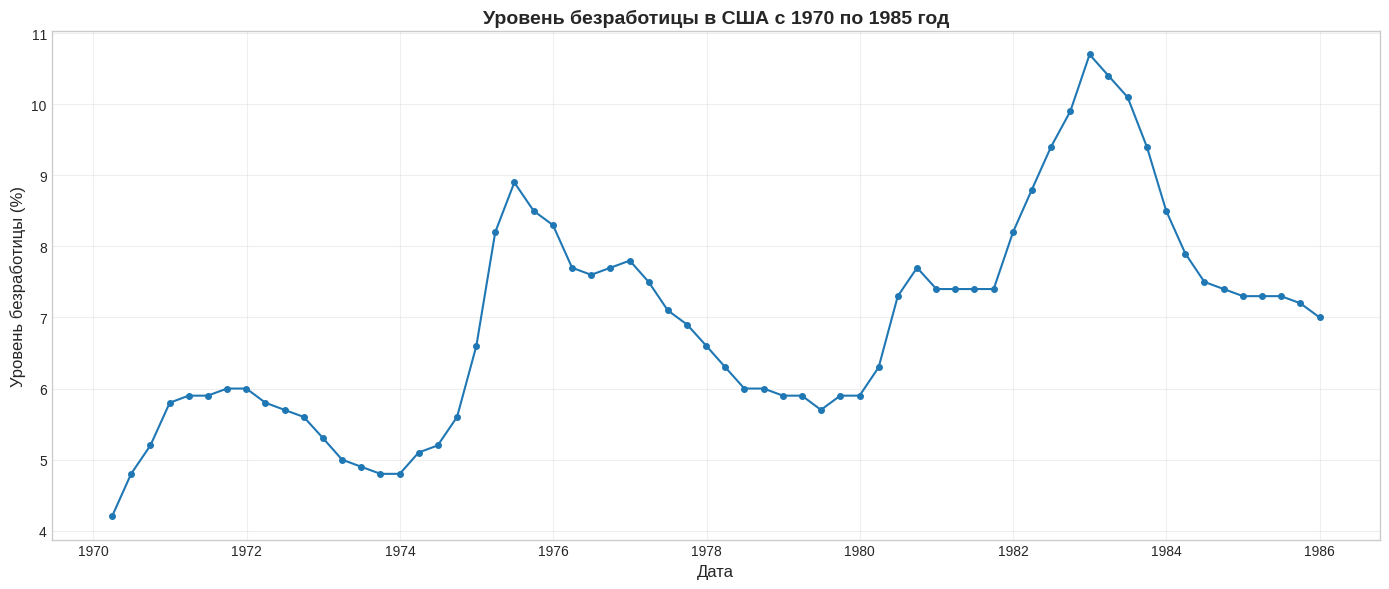


Пункт 3: Логарифмическое преобразование ряда
Первые 5 значений исходного ряда:
date
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2
Name: value, dtype: float64

Первые 5 значений логарифмированного ряда:
date
1959-03-31    1.757858
1959-06-30    1.629241
1959-09-30    1.667707
1959-12-31    1.722767
1960-03-31    1.648659
Name: value, dtype: float64

Статистика логарифмированного ряда:
  Минимум: 1.2238
  Максимум: 2.3702
  Среднее: 1.7429
  Стандартное отклонение: 0.2424


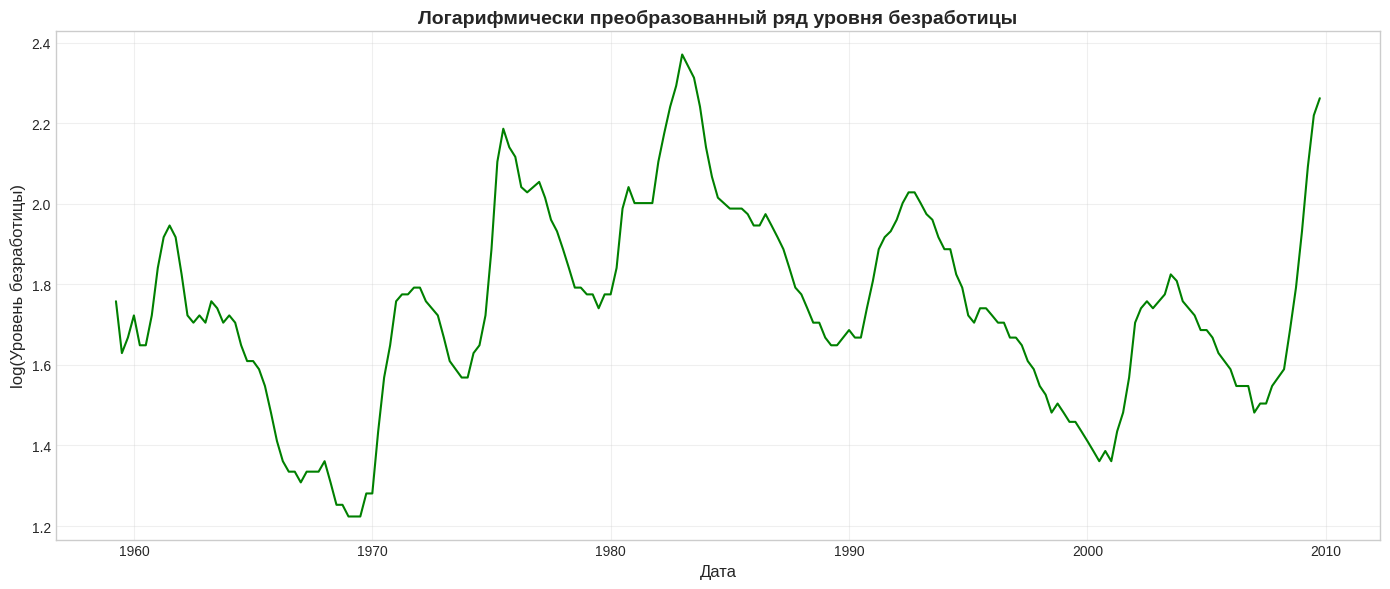


Пункт 4: Проверка стационарности логарифмированного ряда после дифференцирования
Размер дифференцированного ряда: 202
Первые 5 значений дифференцированного ряда:
date
1959-06-30   -0.128617
1959-09-30    0.038466
1959-12-31    0.055060
1960-03-31   -0.074108
1960-06-30    0.000000
Name: value, dtype: float64

Статистика дифференцированного ряда:
  Минимум: -0.1286
  Максимум: 0.2171
  Среднее: 0.0025
  Стандартное отклонение: 0.0537

Результаты теста Дики-Фуллера:
ADF статистика: -4.429023
p-value: 0.000264
Количество использованных наблюдений: 193
Критические значения:
  1%: -3.464694
  5%: -2.876635
  10%: -2.574816

Вывод: Ряд стационарен (p-value = 0.000264 <= 0.05)
Гипотеза о нестационарности отвергается.



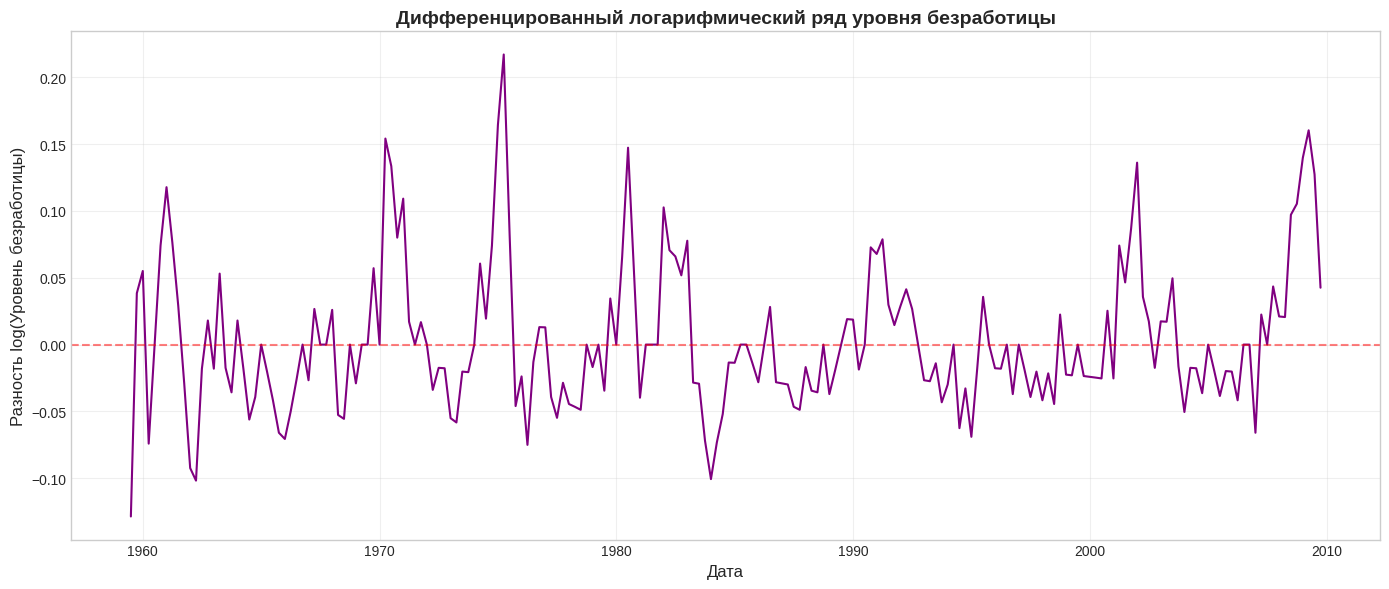


Пункт 5: Обучение модели ARIMA(1,1,2) и прогноз на 15 кварталов
Размер обучающей выборки: 164
Период обучающей выборки: 1959-03-31 00:00:00 - 1999-12-31 00:00:00
Статистика обучающей выборки:
  Минимум: 3.40%
  Максимум: 10.70%
  Среднее: 6.00%

Обучение модели ARIMA(1,1,2)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)



Сводка модели:
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  164
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -12.607
Date:                Mon, 08 Dec 2025   AIC                             33.215
Time:                        20:07:13   BIC                             45.590
Sample:                    03-31-1959   HQIC                            38.239
                         - 12-31-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4829      0.191      2.528      0.011       0.109       0.857
ma.L1          0.2370      0.217      1.094      0.274      -0.188       0.661
ma.L2         -0.0148      0.145    

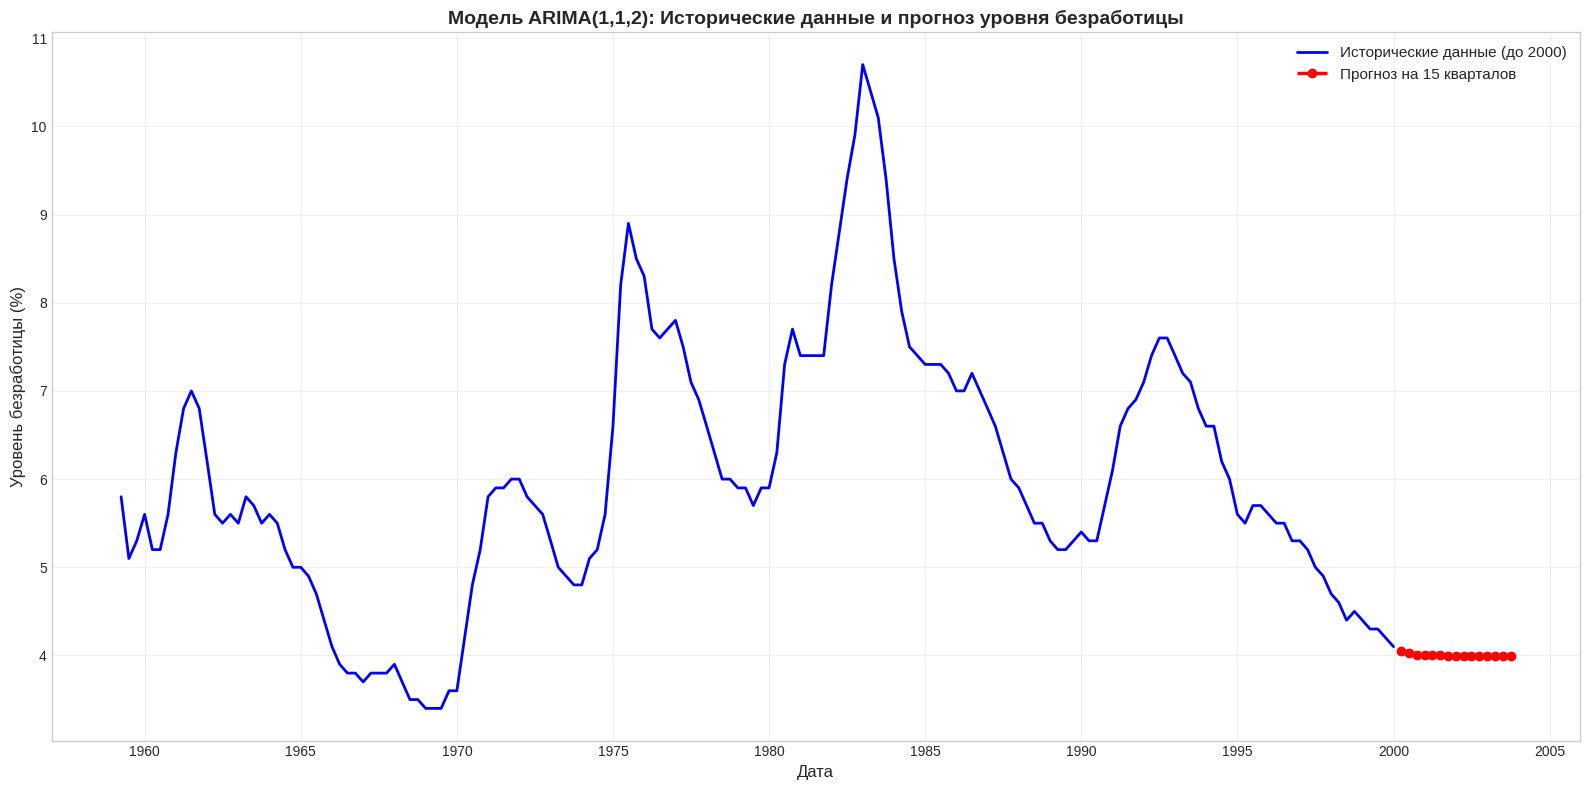

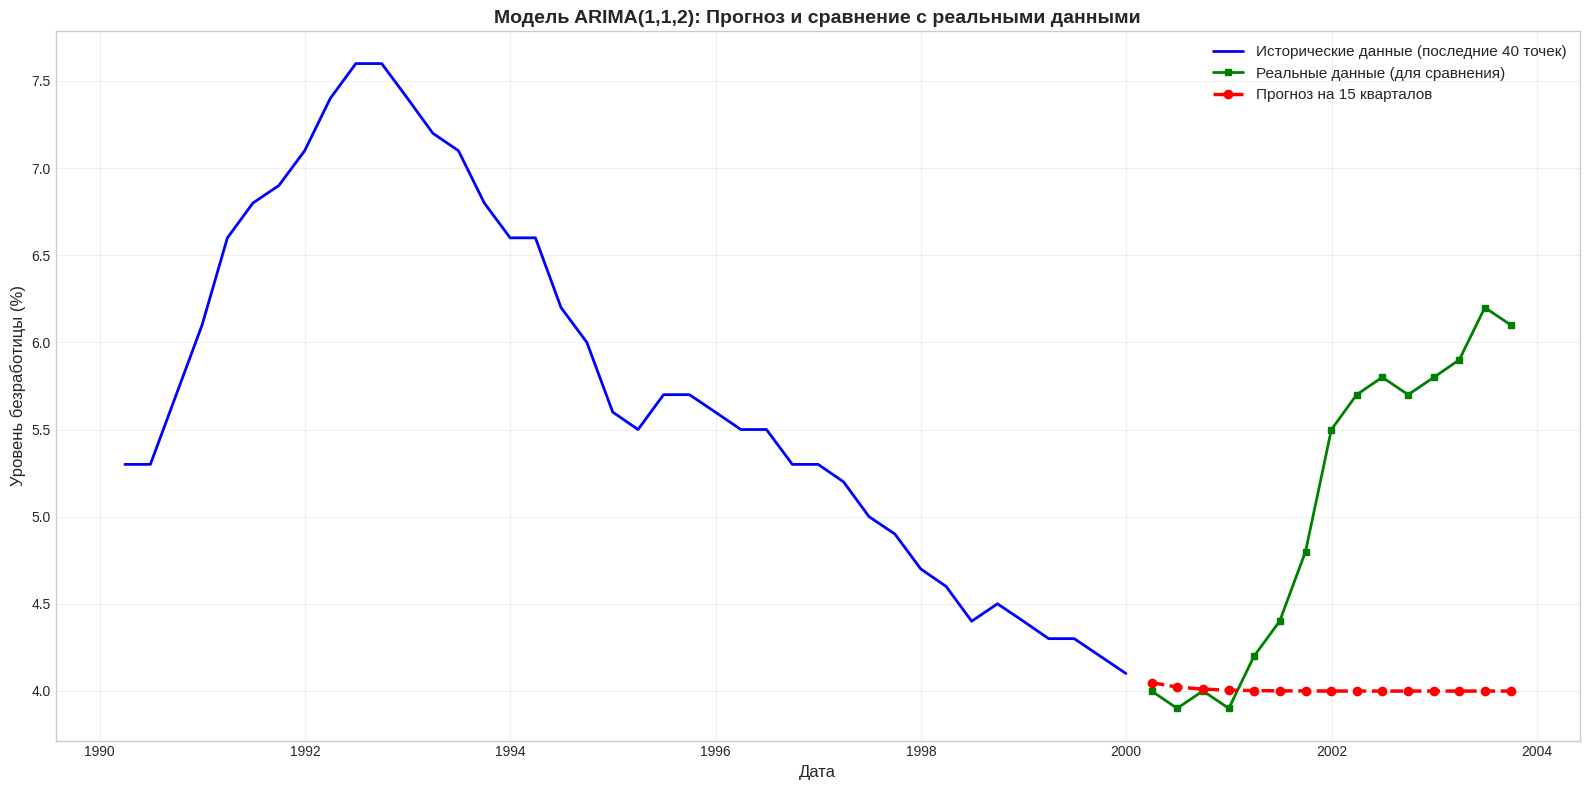


Оценка качества прогноза (сравнение с реальными данными):
RMSE (Root Mean Squared Error): 1.3726%
MAE (Mean Absolute Error): 1.0926%
Среднее реальное значение: 5.06%
Среднее прогнозируемое значение: 4.01%

--- Задание выполнено ---


In [59]:
# Поле для выполнения индивидуального задания
# Пример выполнения для Варианта 1, Задание 2:
# gas_monthly['value']['2005':'2010'].plot()
# plt.title('Производство бензина с 2005 по 2010 год')
# plt.show()

# Войт Иван Иванович
# --- Вариант 10 ---

# --- Пункт 1 ---
# Данные: unemployment_df (уже загружен выше)
print("Пункт 1: Используем данные unemployment_df")
print(f"Размер данных: {unemployment_df.shape}")
print(f"Период данных: {unemployment_df.index.min()} - {unemployment_df.index.max()}")
print(f"Первые 5 строк:\n{unemployment_df.head()}")
print(f"Последние 5 строк:\n{unemployment_df.tail()}")
print()

# --- Пункт 2 ---
# EDA: Постройте график данных за период с 1970 по 1985 год
print("Пункт 2: График данных за период с 1970 по 1985 год")
data_1970_1985 = unemployment_df['value']['1970-01-01':'1985-12-31']
print(f"Количество наблюдений за период 1970-1985: {len(data_1970_1985)}")
print(f"Минимальное значение: {data_1970_1985.min():.2f}%")
print(f"Максимальное значение: {data_1970_1985.max():.2f}%")
print(f"Среднее значение: {data_1970_1985.mean():.2f}%")

plt.figure(figsize=(14, 6))
plt.plot(data_1970_1985.index, data_1970_1985.values, marker='o', markersize=4, linewidth=1.5)
plt.title('Уровень безработицы в США с 1970 по 1985 год', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Уровень безработицы (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print()

# --- Пункт 3 ---
# Преобразование: Примените логарифмическое преобразование (np.log) к ряду и постройте его график
print("Пункт 3: Логарифмическое преобразование ряда")
unemployment_log = np.log(unemployment_df['value'])
print(f"Первые 5 значений исходного ряда:\n{unemployment_df['value'].head()}")
print(f"\nПервые 5 значений логарифмированного ряда:\n{unemployment_log.head()}")
print(f"\nСтатистика логарифмированного ряда:")
print(f"  Минимум: {unemployment_log.min():.4f}")
print(f"  Максимум: {unemployment_log.max():.4f}")
print(f"  Среднее: {unemployment_log.mean():.4f}")
print(f"  Стандартное отклонение: {unemployment_log.std():.4f}")

plt.figure(figsize=(14, 6))
plt.plot(unemployment_log.index, unemployment_log.values, linewidth=1.5, color='green')
plt.title('Логарифмически преобразованный ряд уровня безработицы', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('log(Уровень безработицы)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print()

# --- Пункт 4 ---
# Стационарность: Проверьте на стационарность логарифмированный ряд после одного дифференцирования
print("Пункт 4: Проверка стационарности логарифмированного ряда после дифференцирования")
unemployment_log_diff = unemployment_log.diff().dropna()
print(f"Размер дифференцированного ряда: {len(unemployment_log_diff)}")
print(f"Первые 5 значений дифференцированного ряда:\n{unemployment_log_diff.head()}")
print(f"\nСтатистика дифференцированного ряда:")
print(f"  Минимум: {unemployment_log_diff.min():.4f}")
print(f"  Максимум: {unemployment_log_diff.max():.4f}")
print(f"  Среднее: {unemployment_log_diff.mean():.4f}")
print(f"  Стандартное отклонение: {unemployment_log_diff.std():.4f}")

# Тест Дики-Фуллера
adf_result = adfuller(unemployment_log_diff)
print(f"\nРезультаты теста Дики-Фуллера:")
print(f"ADF статистика: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")
print(f"Количество использованных наблюдений: {adf_result[3]}")
print(f"Критические значения:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.6f}")

if adf_result[1] <= 0.05:
    print(f"\nВывод: Ряд стационарен (p-value = {adf_result[1]:.6f} <= 0.05)")
    print("Гипотеза о нестационарности отвергается.")
else:
    print(f"\nВывод: Ряд не стационарен (p-value = {adf_result[1]:.6f} > 0.05)")
    print("Гипотеза о нестационарности не отвергается.")
print()

# Визуализация дифференцированного ряда
plt.figure(figsize=(14, 6))
plt.plot(unemployment_log_diff.index, unemployment_log_diff.values, linewidth=1.5, color='purple')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.title('Дифференцированный логарифмический ряд уровня безработицы', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Разность log(Уровень безработицы)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print()

# --- Пункт 5 ---
# Прогноз: Обучите модель ARIMA(1,1,2) на данных до 2000 года и сделайте прогноз на 15 кварталов
print("Пункт 5: Обучение модели ARIMA(1,1,2) и прогноз на 15 кварталов")

# Разделение данных: обучающая выборка до 2000 года
train_data = unemployment_df['value'][unemployment_df.index < '2000-01-01']
print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Период обучающей выборки: {train_data.index.min()} - {train_data.index.max()}")
print(f"Статистика обучающей выборки:")
print(f"  Минимум: {train_data.min():.2f}%")
print(f"  Максимум: {train_data.max():.2f}%")
print(f"  Среднее: {train_data.mean():.2f}%")

# Обучение модели ARIMA(1,1,2)
print("\nОбучение модели ARIMA(1,1,2)...")
model = ARIMA(train_data, order=(1, 1, 2))
model_fit = model.fit()
print("\nСводка модели:")
print(model_fit.summary())
print()

# Прогноз на 15 кварталов вперед
forecast_steps = 15
forecast = model_fit.forecast(steps=forecast_steps)
print(f"\nПрогноз на {forecast_steps} кварталов вперед:")
print(forecast)
print(f"\nСтатистика прогноза:")
print(f"  Минимум: {forecast.min():.2f}%")
print(f"  Максимум: {forecast.max():.2f}%")
print(f"  Среднее: {forecast.mean():.2f}%")
print()

# Визуализация: исторические данные и прогноз
plt.figure(figsize=(16, 8))
plt.plot(train_data.index, train_data.values, label='Исторические данные (до 2000)',
         color='blue', linewidth=2)
plt.plot(forecast.index, forecast.values, label=f'Прогноз на {forecast_steps} кварталов',
         color='red', linestyle='--', linewidth=2.5, marker='o', markersize=6)
plt.title('Модель ARIMA(1,1,2): Исторические данные и прогноз уровня безработицы',
          fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Уровень безработицы (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Дополнительно: покажем последние данные и прогноз вместе для лучшей визуализации
if len(unemployment_df) > len(train_data):
    test_data = unemployment_df['value'][unemployment_df.index >= '2000-01-01']
    plt.figure(figsize=(16, 8))
    # Показываем последние 40 точек обучающей выборки для контекста
    plt.plot(train_data.index[-40:], train_data.values[-40:],
             label='Исторические данные (последние 40 точек)', color='blue', linewidth=2)
    if len(test_data) > 0:
        plt.plot(test_data.index[:forecast_steps], test_data.values[:forecast_steps],
                label='Реальные данные (для сравнения)', color='green', linewidth=2, marker='s', markersize=5)
    plt.plot(forecast.index, forecast.values, label=f'Прогноз на {forecast_steps} кварталов',
             color='red', linestyle='--', linewidth=2.5, marker='o', markersize=6)
    plt.title('Модель ARIMA(1,1,2): Прогноз и сравнение с реальными данными',
              fontsize=14, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Уровень безработицы (%)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Если есть реальные данные для сравнения, рассчитаем RMSE
    if len(test_data) >= forecast_steps:
        actual = test_data.values[:forecast_steps]
        predicted = forecast.values
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = np.mean(np.abs(actual - predicted))
        print(f"\nОценка качества прогноза (сравнение с реальными данными):")
        print(f"RMSE (Root Mean Squared Error): {rmse:.4f}%")
        print(f"MAE (Mean Absolute Error): {mae:.4f}%")
        print(f"Среднее реальное значение: {actual.mean():.2f}%")
        print(f"Среднее прогнозируемое значение: {predicted.mean():.2f}%")
print("\n" + "="*60)
print("--- Задание выполнено ---")
print("="*60)
